<center>
<img src="https://raw.githubusercontent.com/FUlyankin/r_probability/master/end_seminars_2020/sem08/real_expect.png" width="800">

# Yet another matstat course: домашнее задание 2
</center>


**ФИО:** Ковель Александр Денисович

**[2 бонусных балла] прикрепите к работе самый крутой мем из своих сохранёнок:**
<center>
<img src="popugaj.jpg"> 
</center>

<center>
<img src="lemonov.jpg"> 
</center>

__Жёсткий дедлайн:__ 23:59MSK 09.03.2025

## Формат сдачи

Сам ноутбук называйте в формате hw-05-USERNAME.ipynb, где USERNAME — ваши фамилия и имя. Файл надо будет сдать в anytask.

В этой домашке мы с вами: 

1. Посмотрим какимы бывают доверительные интервалы для долей
2. Вспомним квантильное преобразование и сгенерируем распределение максимума
3. Построим метрику плохих показов, происследуем её на смещенность и исправим её

## Задача 1: Доверительные интервалы для долей (8 баллов) 

В этой задаче вам предстоит поработать с разными видами доверительных интервалов для долей.

Пусть случайные величины $X_1, \ldots, X_n$ независимы и имеют распределение Бернулли с неизвестным параметром $p$, при этом $\hat p = \bar x$. 

__а) [2 балла]__ Если воспользоваться ЦПТ, можно построить для неизвестного $p$ доверительный интервал Вальда. На паре мы для этого использовали сходимость 

$$
\frac{\hat p - p}{\sqrt{\frac{\hat p (1 - \hat p)}{n}}} \to N(0;1),
$$

а затем решали неравенство 
$$
-z_{cr} \leq \frac{\hat p - p}{\sqrt{\frac{\hat p (1 - \hat p)}{n}}} \leq z_{cr}.
$$

Получалось, что при уровне значимости $\alpha,$ доверительный интервал 

$$
\hat p \pm z_{1 - \frac{\alpha}{2}} \cdot \sqrt{ \frac{\hat p \cdot (1 - \hat p)}{n} }
$$

накрывает неизвестное значение $p$ с вероятностью $1 - \alpha$. 

В этом задании мы, с помощью симуляций на компьютере, сравним фактическую вероятность накрытия неизвестного параметра $p$ интервалами Вальда, Вильсона и Агрести—Коулла c номинальной 95\%-й вероятностью.

### Сеттинг симуляций:

1. Зафиксируем уровень значимости равный $5\%$
2. Будем перебирать $p$ в интервале $(0, 1)$ с шагом в 0.01
3. Для каждого p проведем $1000$ симуляций
    - генерируем с заданным $p$ выборку размера $n = 10$
    - строим доверительный интервал для $p$
    - cмотрим попадает ли истинное значение в доверительный интервал
4. Оцениваем по симуляциям получившийся уровень значимости (доля случаев, когда доверительный интервал не покрыл $p$).
5. Рисуем картинку, где по оси абсцис отложены значения $p$, а по оси ординат полученная оценка уровня значимости. Отдельной пунктирной линией рисуем на картинке $0.05$. 

Картинка должна получиться примерно такой же как [в этой статье.](https://www.ime.usp.br/~jmsinger/Textos/Castroetal2019.pdf)

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

alpha = 0.05
confidence_level = 1 - alpha
p_values = np.arange(0.01, 1.0, 0.01)

In [23]:
def get_wald(z, sample, n) -> tuple[float, float]:
    phat = sample / n 
    se = np.sqrt(phat * (1 - phat) / n)
    ci_wald_lower = phat - z * se
    ci_wald_upper = phat + z * se
    return ci_wald_lower, ci_wald_upper 

In [24]:
def create_simulation(func, p_values, alpha=0.05, n=10, num_simulations=1000) -> list:
    coverage_list = []
    
    for p in p_values:
        coverage = 0

        for _ in range(num_simulations):
            sample = np.random.binomial(n, p)
            z = norm.ppf(1 - alpha / 2)

            lower, upper = func(z, sample, n)
            if lower <= p <= upper:
                coverage += 1
        coverage_list.append(coverage / num_simulations)
    return coverage_list

In [27]:
def draw_sim_plot(p_values, coverage_list, confidence_level=0.95, label="Интервал Очень Важного человека"):
    plt.figure(figsize=(10, 6))
    plt.plot(p_values, coverage_list, label=label, color='blue')
    plt.axhline(y=confidence_level, color='red', linestyle='--', label='Номинальная 95% вероятность')
    plt.title('Сравнение покрытия доверительных интервалов')
    plt.xlabel('Вероятность успеха (p)')
    plt.ylabel('Доля покрытия')
    plt.legend()
    plt.grid()
    plt.ylim(0, 1)
    plt.show()

In [48]:
coverage_wald = create_simulation(get_wald, p_values, n=100)

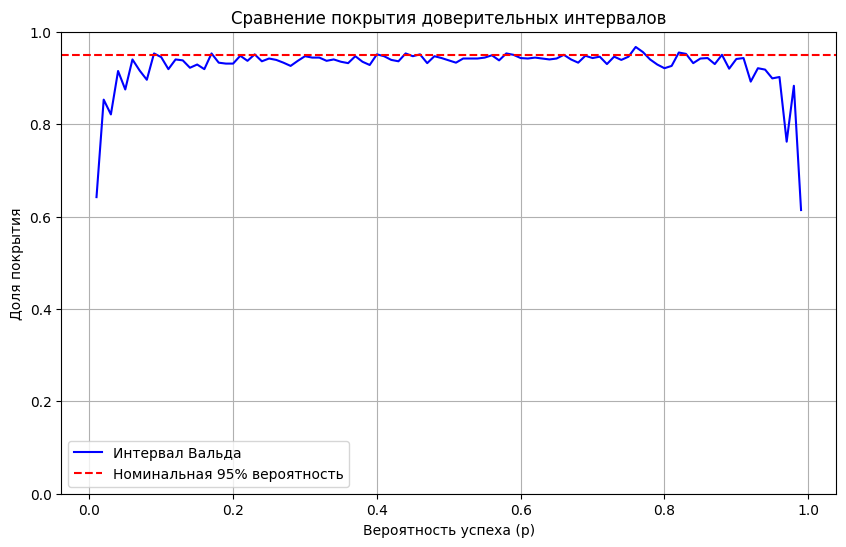

In [49]:
draw_sim_plot(p_values, coverage_wald, label='Интервал Вальда')

__б) [2 балла]__ Можно не заменять в дисперсии значения $p$ на $\hat p$, а вместо этого воспользоваться сходимостью 

$$
\frac{\hat p - p}{\sqrt{\frac{p (1 - p)}{n}}} \to N(0;1)
$$

и решить относительно неизвестного $p$ (о ужас!) квадратное неравенство. Выйдет доверительный интервал Уилсона: 

$$
\hat p_w \pm z_{1 - \frac{\alpha}{2}} \cdot \sqrt{\frac{u \hat p (1 - \hat p) + (1 - u) (1/2)^2 }{n_w}},
$$
где $\quad$ $\hat p_w = u \hat p + (1 - u) (1/2)$, $\quad$  $u = \frac{n}{n + z_{1 - \frac{\alpha}{2}}^2}$, $\quad$ $(1-u) = \frac{z_{1 - \frac{\alpha}{2}}^2}{n + z_{1 - \frac{\alpha}{2}}^2}$,  $\quad$
  $n_w = n + z_{1 - \frac{\alpha}{2}}^2$.

**Необязательно:** с помощью ручки и бумаги убедитесь, что эти формулы верны.

In [33]:
def get_wilson(z, sample, n):
    phat = sample / n 
    
    nw = n + z * z
    u = n / nw
    pwhat = u * phat + (1 - u) / 2
    
    adjusted_se = np.sqrt((u * phat * (1 - phat) + (1 - u) / 4) / nw) 
    
    ci_wilson_lower = pwhat - z * adjusted_se
    ci_wilson_upper = pwhat + z * adjusted_se
    return ci_wilson_lower, ci_wilson_upper

Повторите для доверительного интервала Уилсона тот же самый эксперимент и постройте картинку с поведением уровня значимости в зависимости от значений $p$. 

In [34]:
coverage_wilson = create_simulation(get_wilson, p_values)

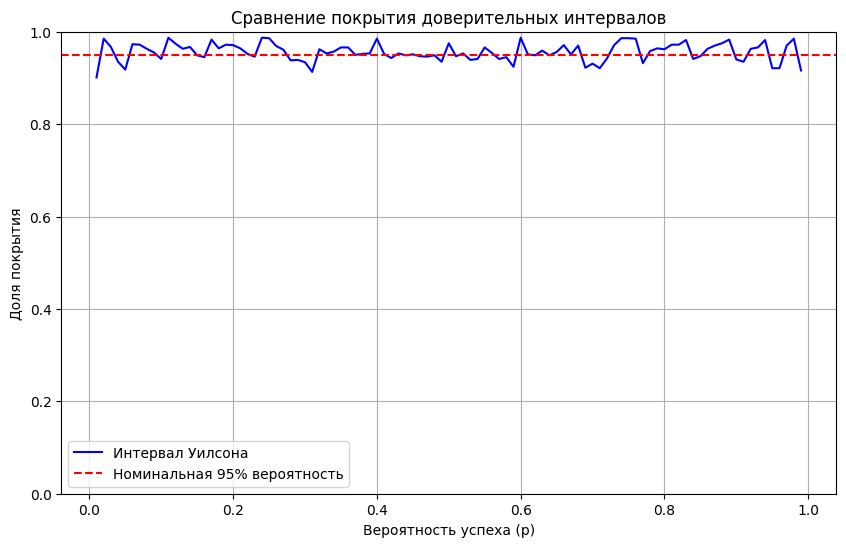

In [35]:
draw_sim_plot(p_values, coverage_wilson, label='Интервал Уилсона')

### Блок необязательных заданий

> Эти задания вы можете попытаться решить на бумаге сами. Если вам лень это делать, достаточно их прочитать и как следует осмыслить ответы. 

**Задание 1:** 

Обозначим центр интервала Вильсона с помощью $\hat p_w$. С помощью ручки и  бумаги докажите, что центр интервала Вильсона $\hat p_w$ можно представить как средневзвешенное классической оценки $\hat p$ и тривиальной оценки $1/2$,

$$
\hat p_w = u \cdot \hat p + (1 - u) \cdot (1/2).  
$$

Найдите веса $u$ и $(1-u)$.

**Ответ:**  $u = \frac{n}{n + z_{cr}^2}$, $\quad$ $(1-u) = \frac{z_{cr}^2}{n + z_{cr}^2}$.

**Задание 2:**  Докажите, что центр интервала Вильсона $\hat p_w$ можно проинтерпретировать следующим образом: добавим $f$ вымышленных $1$ и $f$ вымышленных $0$ в выборку и посчитаем классическую оценку вероятности для выборки с вымышленными наблюдениями,

$$
\hat p_w = \frac{\sum_{i=1}^n Y_i + f}{n + 2 f}.
$$

Какому целому числу примерно равно $f$ для 95\%-го доверительного интервала?

__Ответ:__ 

$$
\hat p_w = \frac{\sum Y_i + z_{cr}^2/2}{n + z_{cr}^2},
$$

то есть мы добавляем в выборку $f = z_{cr}^2/2$ вымышленных $1$ и столько же вымышленных $0$. 

**Задание 3:**  Докажите, что интервал Вильсона можно записать в виде

$$
\hat p_w \pm z_{cr} \cdot \sqrt{\frac{u \cdot \hat p (1 - \hat p) + (1 - u) \cdot (1/2)^2 }{n_w}}.
$$

Найдите $n_w$, а также веса $u$ и $(1 - u)$.

__Ответ:__

$\hat p_w = u \cdot \hat p + (1 - u) \cdot (1/2)$, $\quad$ $u = \frac{n}{n + z_{cr}^2}$, $\quad$  $(1-u) = \frac{z_{cr}^2}{n + z_{cr}^2}$, $\quad$ $n_w = n + z_{cr}^2$.

Таким образом, интервал Вильсона слегка корректирует число наблюдений и использует в качестве оценки дисперсии $X_i$ средневзвешенное между классической оценкой $\hat p (1 - \hat p)$ и тривиальной оценкой $1/4$.

__в) [1 балл]__ Доверительный интервал Агрести—Коулла для уровня доверия 95\% строится следующим образом.
В выборку мысленно добавляют два наблюдения равных $1$ и два наблюдений равных $0$,
считают оценку доли
$$
\hat p_{ac} = \frac{\sum_{i=1}^n Y_i + 2}{n + 4},  
$$ 
а затем строят классический интервал Вальда, используя $\hat p_{ac}$ вместо классической $\hat p$. 

Повторите для доверительного интервала Агрести—Коулла тот же самый эксперимент и постройте картинку с поведением уровня значимости в зависимости от значений $p$. 

In [41]:
def get_agresti_coull(z, sample, n):
    n_adj = n + z**2
    p_adj = (sample + z**2 / 2) / n_adj
    se_adj = np.sqrt(p_adj * (1 - p_adj) / n_adj)
    
    ci_agresti_coull_lower = p_adj - z * se_adj
    ci_agresti_coull_upper = p_adj + z * se_adj
    
    return ci_agresti_coull_lower, ci_agresti_coull_upper

In [51]:
coverage_agresti_coull = create_simulation(get_agresti_coull, p_values, n=100)

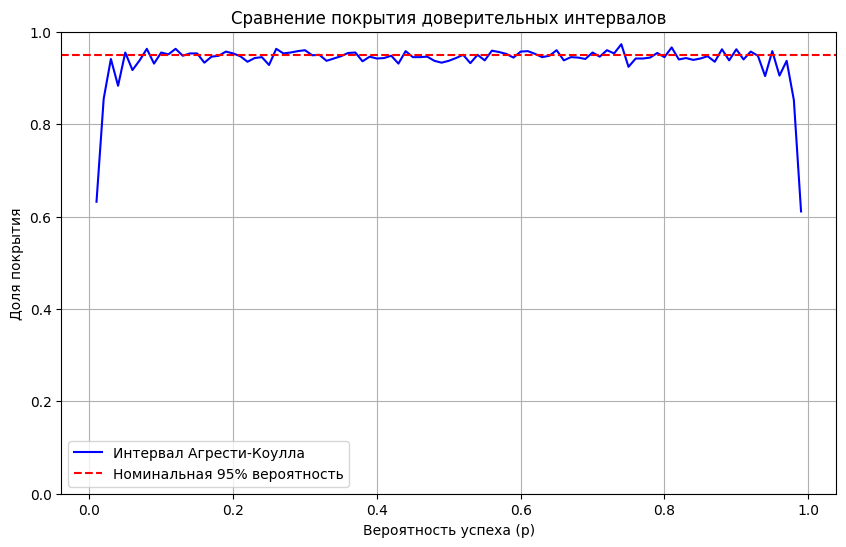

In [52]:
draw_sim_plot(p_values, coverage_agresti_coull, label='Интервал Агрести-Коулла')

__г) [1 балл]__ С помощью [метода стабилизации дисперсии](https://youtu.be/JGNwZKwE2h0) для $p$ можно получить следующий доверительный интервал: 

$$
\sin^2 \left(\arcsin \sqrt{\hat p} \pm \frac{z_{cr}}{2 \sqrt{n}} \right).
$$

Проведите для него тот же самый эксперимент.

In [44]:
def get_agresti_coull(z, sample, n):
    phat = sample / n
    ci_sin_lower = -1
    ci_sin_upper = - 1 
    if phat > 0: 
        z_cr = z / 2
        arcsin_sqrt_phat = np.arcsin(np.sqrt(phat))
        ci_sin_lower = np.sin(arcsin_sqrt_phat - z_cr / np.sqrt(n))**2
        ci_sin_upper = np.sin(arcsin_sqrt_phat + z_cr / np.sqrt(n))**2
    return ci_sin_lower, ci_sin_upper

In [45]:
coverage_sin_square = create_simulation(get_agresti_coull, p_values)

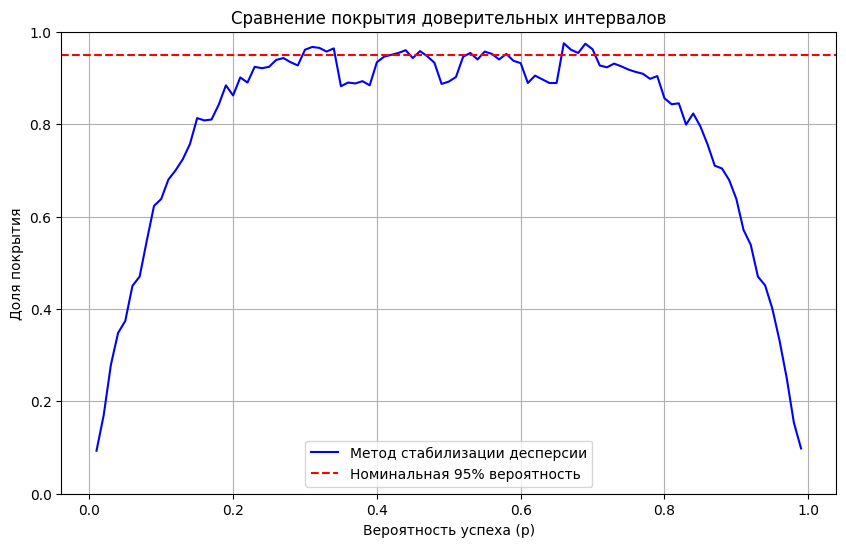

In [47]:
draw_sim_plot(p_values, coverage_sin_square, label='Метод стабилизации десперсии')

__д) [2 балла]__ Дайте развёрнутый ответ на следующие вопросы.

1. Правда ли, что при уровне доверия 95\% центры интервала Агрести — Коулла и Вильсона совпадают?

__Ответ:__ Да

2. Какой 95\%-й интервал шире, Агрести—Коулла или Вильсона?

__Ответ:__ Вильсона. Исходя из графика (по идее должен быть Агрести — Коулла)

3. Какой 95\%-й интервал шире, Вальда или основанный на стабилизации дисперсии?

__Ответ:__ На симуляции получилось на стабилизации десперсии

4. Как доверительные интервалы ведут себя на краях? Как они ведут себя в середине?

__Ответ:__  На краях узкие. По середине широкие

5. Перезапустите код при $n=100$. Насколько драматично изменилась картинка? 

__Ответ:__ Да, драматично

Что почитать:

- [Статья Денга про дельта-метод](https://alexdeng.github.io/public/files/kdd2018-dm.pdf)
- [Выводим распределение для дисперсии и строим асимптотические доверительные интервалы](https://www.stat.umn.edu/geyer/s06/5102/notes/ci.pdf) (тут же есть про стабилизацию дисперсии и многое другое)
- [Доверительный интервал Уилсона](https://www.econometrics.blog/post/the-wilson-confidence-interval-for-a-proportion/)
- [Доверительный интервал Агрести-Коула](https://www.econometrics.blog/post/don-t-use-the-textbook-ci-for-a-proportion/)
- [Сравниваем разные доверительные интервалы для долей](https://www.ime.usp.br/~jmsinger/Textos/Castroetal2019.pdf)

## Задача 2: квантильное преобразование (2 балла)

Компьютер хорошо умеет генерировать равномерные случайные величины. Для разных популярных распределений, вроде нормального, люди также смогли придумать хорошие генераторы. Но что делать, если нам хочется научиться генерировать что-то специфическое? В этом людям помогает квантильное преобразование!

#### Теорема:

Пусть функция распределения $F_X(x)$ непрерывна. Тогда случайная величина $Y = F(X)$ имеет равномерное распределение на отрезке $[0; 1]$.


#### Следствие:

Пусть $Y \sim U[0;1]$, а $F(x)$ произвольная функция распределения. Тогда случайная величина $X = F^{-1}(Y)$ будет иметь функцию распределения $F(x)$.


#### Что это нам даёт:


- Позволяет генерировать из равномерного распределения другие. Достаточно найти обратную функцию и вычислить её значение от каждого элемента в выборке.
- Применимо невсегда, напрмер, для нормального распределения используют другие алгоритмы, так как функцию распределения для него невозможно записать аналитически.

<center>
<img src="https://raw.githubusercontent.com/FUlyankin/matstat-AB/main/week05_LLN_CLT/image/quant.png" height="200"> 
</center>


__Полезные видео и код:__ 

- [Видео с объяснением квантильного преобразования](https://www.youtube.com/watch?v=Dxtj-3N22_A&list=PLCf-cQCe1FRyg1ajZ2HJVKknbuTujBOLN&index=9)
- [Видео с его использованием в питоне](https://www.youtube.com/watch?v=ivpWyorfWlA&list=PLCf-cQCe1FRyg1ajZ2HJVKknbuTujBOLN&index=10)
- [Тетрадка с кодом из видео](https://github.com/FUlyankin/matstat-AB/blob/main/week05_LLN_CLT/09_python_distributions.ipynb)
- [Лекция Фила из маги по терверу с подробным разбором квантильного преобразования и выведением функции распределения максимума](https://www.youtube.com/watch?v=vvpRREpe0Bw)
- [Выведение функции распределения для максимума в учебнике Черновой](https://tvims.nsu.ru/chernova/tv/lec/node68.html)


Пуcть у нас есть стрёмная функция распределения: 

$$
F(x) = \left( \frac{\ln x}{\ln \theta} \right)^{\alpha},  \quad x \in [1; \theta]
$$

__а) [1 балл]__ Сгенерируйте из него выборку с помощью квантильного преобразования. Параметры $\alpha$ и $\theta$ возьмите на свой вкус. Для получившейся выборки постройте гистограмму.

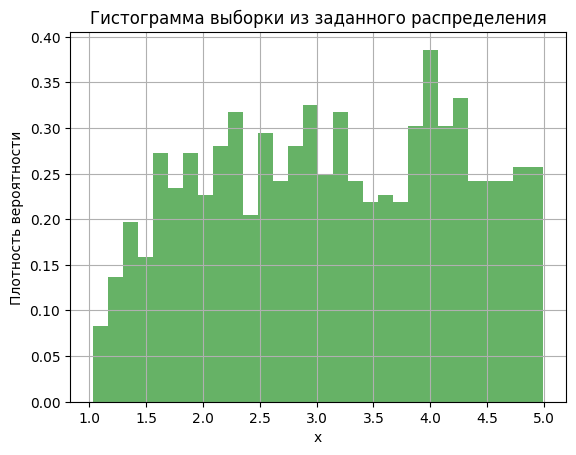

In [53]:
theta = 5
alpha = 2
n = 1000  

u = np.random.uniform(0, 1, n)
x = theta ** (np.sqrt(u))

plt.hist(x, bins=30, density=True, alpha=0.6, color='g')
plt.title('Гистограмма выборки из заданного распределения')
plt.xlabel('x')
plt.ylabel('Плотность вероятности')
plt.grid()
plt.show()

__б) [1 балл]__ Пусть случайные величины $X_1, \ldots, X_n \sim U[0;1].$ Пусть $Y_n = max(X_1, \ldots, X_n).$ 

Мы знаем, что $F_{Y_n}(x) = x^n,$ если $x \in [0; 1].$ 

Напишите функцию, которая сгенерирует с помощью квантильного преобразования выборку из распределения $F_{Y_n}(t)$.

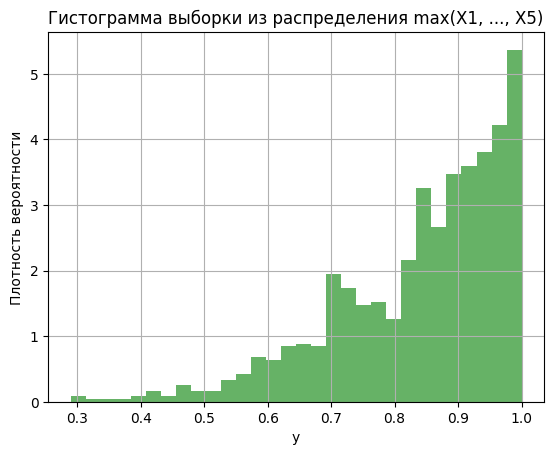

In [54]:
def generate_max_uniform_sample(n, size):
    u = np.random.uniform(0, 1, size)
    y = u**(1/n)
    return y

n = 5 
sample_size = 1000 
samples = generate_max_uniform_sample(n, sample_size)


plt.hist(samples, bins=30, density=True, alpha=0.6, color='g')
plt.title(f'Гистограмма выборки из распределения max(X1, ..., X{n})')
plt.xlabel('y')
plt.ylabel('Плотность вероятности')
plt.grid()
plt.show()